In [67]:
import numpy as np
from joblib import Parallel, delayed

In [68]:
x = [[1, 2, 3, 4], [4, 5, 6, 2], [7, 8, 9, 1]]
x = np.array(x)
x

array([[1, 2, 3, 4],
       [4, 5, 6, 2],
       [7, 8, 9, 1]])

In [69]:
x.shape[0]

3

In [70]:
z = (x[0] - x[1])
(z**2).sum()

31

In [92]:
c = (x[0] - x)**2

c = np.sqrt(c.sum(axis = 1))
c

array([ 0.        ,  5.56776436, 10.81665383])

In [126]:
yy = np.array([6, 2, 3])

dc = np.array([c, yy])
dc

array([[ 0.        ,  5.56776436, 10.81665383],
       [ 6.        ,  2.        ,  3.        ]])

In [127]:
dc = sorted(dc.T.tolist(), key = lambda x: x[0])
dc

[[0.0, 6.0], [5.5677643628300215, 2.0], [10.816653826391969, 3.0]]

# Write the KNN Class

In [ ]:
'''When I first implemented this class it took about 60 mins for prediction on the MNSIT Dataset
I tried parallizing some processes with joblib and using numpy purely for others so that it takes about 4 mins only for prediction now'''


class KNNClassifier:
    def __init__(self, neighbors = 5) -> None:
        self.k = neighbors
        
        self.X = None
        self.y = None
        
        self.counts = dict()
        
    def train(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
        
        for i in y:
            if i not in self.counts.keys():
                self.counts[i] = 0
        
    def nearest_neighbors(self, x):
        
        # Calculate the distance between x and all training points
        distance = np.sqrt(((x - self.X)**2).sum(axis = 1))
        
        # Assign each distance and the class it corresponds to (index order is preserved this way) to neighbors
        neighbors = np.array([distance, self.y])
        
        # Once we got all examples and their distances from x, sort them ascendingly based on distance. 
        # Transpose to pair each distance with its class instead of having to different lists one for distances and one for classes 
        neighbors = sorted(neighbors.T.tolist(), key = lambda x: x[0])
        
    
        # Take the nearest k neighbors to x
        neighbors = neighbors[:self.k]
        
        return neighbors
    
    def classify(self, x):
        nearest_neighbors = self.nearest_neighbors(x)
        
        # Copy counts first to not make any error across instances
        classes = self.counts.copy()
        
        # For each neighbor, vote for their class through the counts dictionary
        for neighbor in nearest_neighbors:
            classes[neighbor[1]] += 1
            
        # Get the class with majority of votes and put it into the answers
        winner_class = sorted(classes.items(), key = lambda class_votes: class_votes[1], reverse = True)[0][0]
            
        return winner_class
        
    def predict(self, X: np.ndarray):
        # number of examples to get neighbors from
        m = self.X.shape[0]
        
        # Answers for the array X given to classify
        classifications = []
        
        # Get the majority class for point given all saved examples from training
        # Using all CPU cores available, we will classify each point we want to predict in parallel using joblib
        classifications = Parallel(n_jobs = -1)(delayed(self.classify)(x) for x in X)
            
                
                
        return classifications
                
            

# Lets test our class

In [156]:
import pandas as pd

*We will use MNSIT Dataset for testing*

In [73]:
mnsit = pd.read_csv('MNSIT.csv')

In [74]:
from sklearn.model_selection import train_test_split

In [175]:
y = mnsit['label']
X = mnsit[mnsit.columns[1:]]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 420, stratify = y)
knn = KNNClassifier(neighbors = 15)
knn.train(x_train.to_numpy(), y_train.to_numpy())

In [176]:
y_pred = knn.predict(x_test.to_numpy())

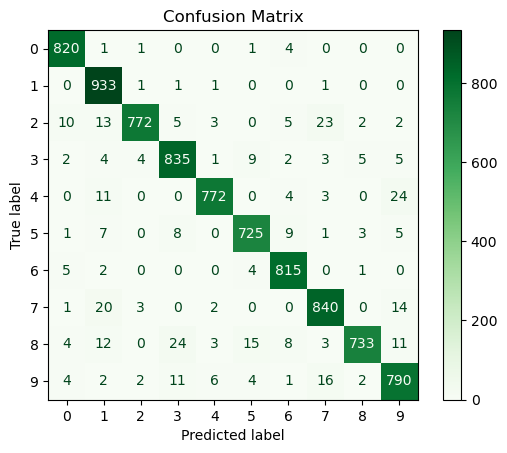

In [177]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix")
plt.show()

In [178]:
report = classification_report(y_test, y_pred, zero_division = 'warn')
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       827
           1       0.93      1.00      0.96       937
           2       0.99      0.92      0.95       835
           3       0.94      0.96      0.95       870
           4       0.98      0.95      0.96       814
           5       0.96      0.96      0.96       759
           6       0.96      0.99      0.97       827
           7       0.94      0.95      0.95       880
           8       0.98      0.90      0.94       813
           9       0.93      0.94      0.94       838

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



In [179]:
acc = accuracy_score(y_test, y_pred)
acc

0.9565476190476191